## René Parlange, MSc
### 📚 Gravitational Lensing Course, PhD in Computer Science
#### 🎓 Instructors: Dr. Octavio Valenzuela (IA-UNAM), Dr. Juan Carlos Cuevas (UASLP) and Dr. Omar Cabrera (IA-UNAM)
#### 🏛 Universidad Autónoma de San Luis Potosí (UASLP)

🔗 [GitHub Repository](https://github.com/parlange/gravitational-lensing)



In this example, we implement the calculation of the deflection angle field by an
extended lens **bold text**.

A two-dimensional map of the lens surface density is provided by the
fits file **kappa_2.fits**. The map was obtained by projecting the mass distribution
of a dark matter halo obtained from an N-body simulation (Meneghetti et al. 2017).

To be precise, this is the surface density divided by a constant which depends on
the lens and source redshifts (we will talk about this constant in the next chapter).
This quantity is called *convergence*, κ.

As we pointed out in Sect. 2.4, this integral is a convolution. In Fourier Space, it
becomes a multiplication.

We consider a **convergence map** of *npix* × *npix* pixels, i.e. the function to be
convolved is sampled at a certain number of positions on a regular grid, where the
pixel on the m-th row and n-th column is identified with the couple of indices (m, n).
We will use **Discrete Fourier Transforms (DFTs)** to implement the convolution.

A common algorithm to compute **DFTs** is the socalled **Fast Fourier Transform (FFT)** algorithm (Cooley and Tukey 1965), which
is implemented in many python packages. Here, we use the **numpy.fft** module:

In [5]:
import numpy as np
import numpy.fft as fftengine

To deal with **lenses described by convergence maps**, we define a class called
**deflector**. This class, shown here below, contains some methods that will be
described in detail later.

This class, shown here below, contains some methods that will be
described in detail later. They allow to:

• build the kernel K(x)

• compute the deflection angle map by convolving the convergence with the kernel

• perform the so-called zero-padding

• crop the zero-padded maps

We initialize a deflector object by reading the fits file containing the lens
convergence map. For this purpose, we import the astropy.io.fits module.

In [6]:
import astropy.io.fits as pyfits  # Import the FITS file handling module from astropy

class deflector(object):  # Define the class 'deflector'

    # Initialize the deflector with a surface density map
    def __init__(self, filekappa, pad=False):
        kappa, header = pyfits.getdata(filekappa, header=True)  # Load the kappa (convergence) data and header from a FITS file
        self.kappa = kappa  # Store the kappa map in the class instance
        self.nx = kappa.shape[0]  # Store the x-dimension of the kappa map
        self.ny = kappa.shape[1]  # Store the y-dimension of the kappa map
        self.pad = pad  # Store the boolean value indicating whether to use zero-padding
        if (pad):  # If padding is requested,
            self.kpad()  # call the method to apply zero-padding to the kappa map
        self.kx, self.ky = self.kernel()  # Calculate and store the kernel for convolution

    # Define the kernel function for the convolution
    def kernel(self):
        x = np.linspace(-0.5, 0.5, self.kappa.shape[0])  # Create a linear space for x-axis
        y = np.linspace(-0.5, 0.5, self.kappa.shape[1])  # Create a linear space for y-axis
        kx, ky = np.meshgrid(x, y)  # Create a meshgrid from x and y arrays
        norm = (kx**2 + ky**2 + 1e-12)  # Calculate the norm, avoiding division by zero
        kx = kx / norm / np.pi  # Normalize kx with the norm and scale
        ky = ky / norm / np.pi  # Normalize ky similarly
        return(kx, ky)  # Return the normalized kx and ky arrays

    # Compute the deflection angles by convolving the surface density with the kernel
    def angles(self):
        kappa_ft = fftengine.fftn(self.kappa, axes=(0, 1))  # Fourier transform of the kappa map
        kernelx_ft = fftengine.fftn(self.kx, axes=(0, 1), s=self.kappa.shape)  # Fourier transform of the kx kernel, matching kappa shape
        kernely_ft = fftengine.fftn(self.ky, axes=(0, 1), s=self.kappa.shape)  # Fourier transform of the ky kernel, likewise
        # Convolve in Fourier space and inverse transform to get deflection angles
        alphax = 2.0 / (self.kappa.shape[0]) / (np.pi)**2 * fftengine.fftshift(fftengine.ifftn(2.0 * np.pi * kappa_ft * kernelx_ft))
        alphay = 2.0 / (self.kappa.shape[0]) / (np.pi)**2 * fftengine.fftshift(fftengine.ifftn(2.0 * np.pi * kappa_ft * kernely_ft))
        return(alphax.real, alphay.real)  # Return the real parts of the deflection angles

    # Return the kappa map directly
    def kmap(self):
        return(self.kappa)

    # Apply zero-padding around the kappa map
    def kpad(self):
        def padwithzeros(vector, pad_width, iaxis, kwargs):  # Define a function for padding with zeros
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # Apply the padding around the kappa map
        self.kappa = np.lib.pad(self.kappa, self.kappa.shape[0], padwithzeros)

    # Crop the maps to remove zero-padded areas, returning to the original size
    def mapCrop(self, mappa):
        xmin = int(self.kappa.shape[0] / 2 - self.nx / 2)
        ymin = int(self.kappa.shape[1] / 2 - self.ny / 2)
        xmax = int(xmin + self.nx)
        ymax = int(ymin + self.ny)
        mappa = mappa[xmin:xmax, ymin:ymax]
        return mappa

We begin by building a deflector and using it to compute the deflection angles
employing the method angles:

The function **kmap** returns the *convergence map read from the fits file* as a **numpy
array**. We visualize this map and the maps of the two components of the deflection
angles as in Fig. 2.4 using the following instructions:

In [7]:
df=deflector('kappa_gl.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

#plot the results
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

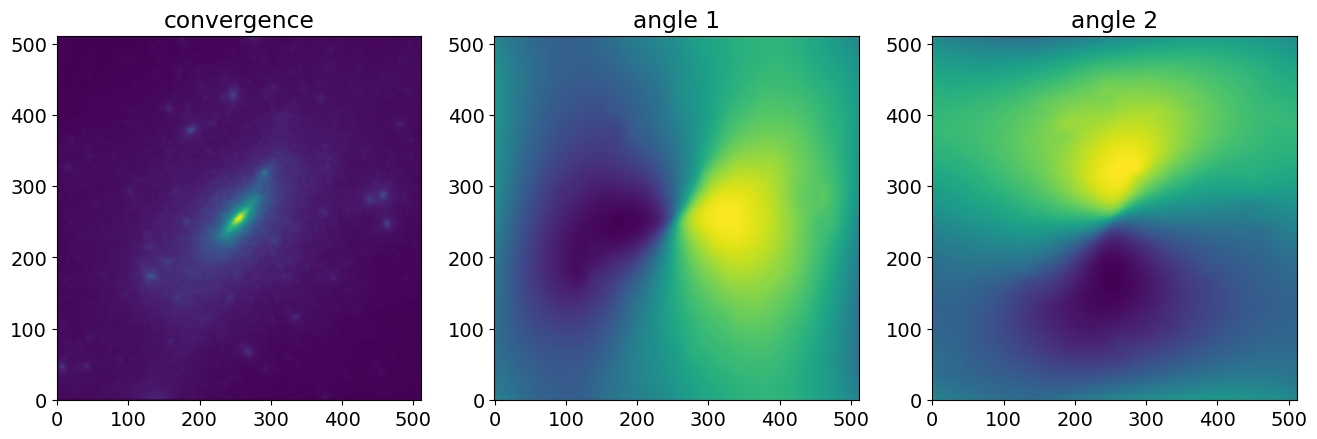

In [8]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('no_padding.png')

Note that, when creating the instance df of deflector, we did not change
the default value of the keyword pad, which is then set to False. Now we
explain the usage of this keyword. The **computation of the DFTs assumes periodic
boundary conditions**. In other words, we can imagine that the **lens mass distribution
is replicated** outside the boundaries of the map **indefinitely** and **periodically**.

Other identical lenses virtually surround the lens, and each of them contributes to the
light deflection. Given that the region around the lens considered in this example is
relatively small, we expect that the deflection angles will be biased near the borders,
where light rays can feel the pull of the mass outside the map.

The three panels in
Fig. 2.4 show the maps of the convergence and the two components of the deflection
angles obtained with this setting

To mitigate this bias, we can use a method called **zero-padding**. Zero-padding
consists of creating a **buffer all around the convergence map, where the convergence
is set to zero**. By doing so, we *increase the size of the original map*, but we expect
to **increase the accuracy of the calculations near the borders**, because the periodic
conditions are better reproduced in this setting. We activate zero-padding by setting
the variable pad=True when initializing the deflector. Then, the function kpad
does the job:

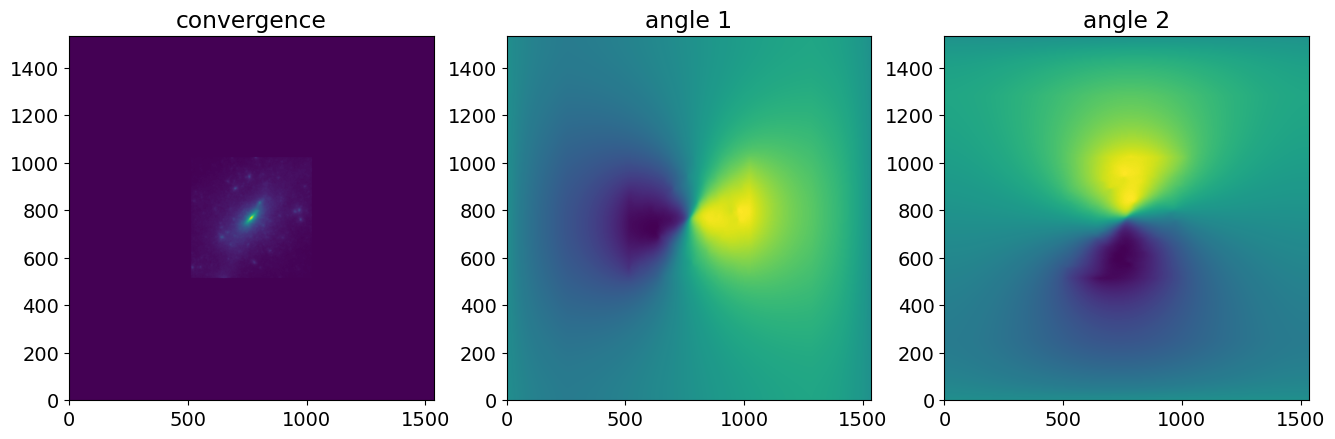

In [9]:
df=deflector('kappa_gl.fits',True)
angx,angy=df.angles()
kappa=df.kmap()

fig,ax = plt.subplots(1,3,figsize=(16,8))
angx,angy=df.angles()
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('padding.png')

In the example shown in Fig. 2.5, we zealously increase the size of the map by a
factor of 3 in each dimension. We are not interested in this large, zero-padded area,
thus we can get rid of the values outside the footprint of the original convergence
map by using the function mapCrop:

In [10]:
angx=df.mapCrop(angx)
angy=df.mapCrop(angy)

We show the cropped deflection angle maps in the upper panels of Fig. 2.6. For
comparison, we also show the maps obtained without zero-padding in the bottom panels. As expected, we see that the maps differ significantly along the borders. It is
imperative to perform zero-padding when using the method outlined in this example
to calculate the deflection angles.

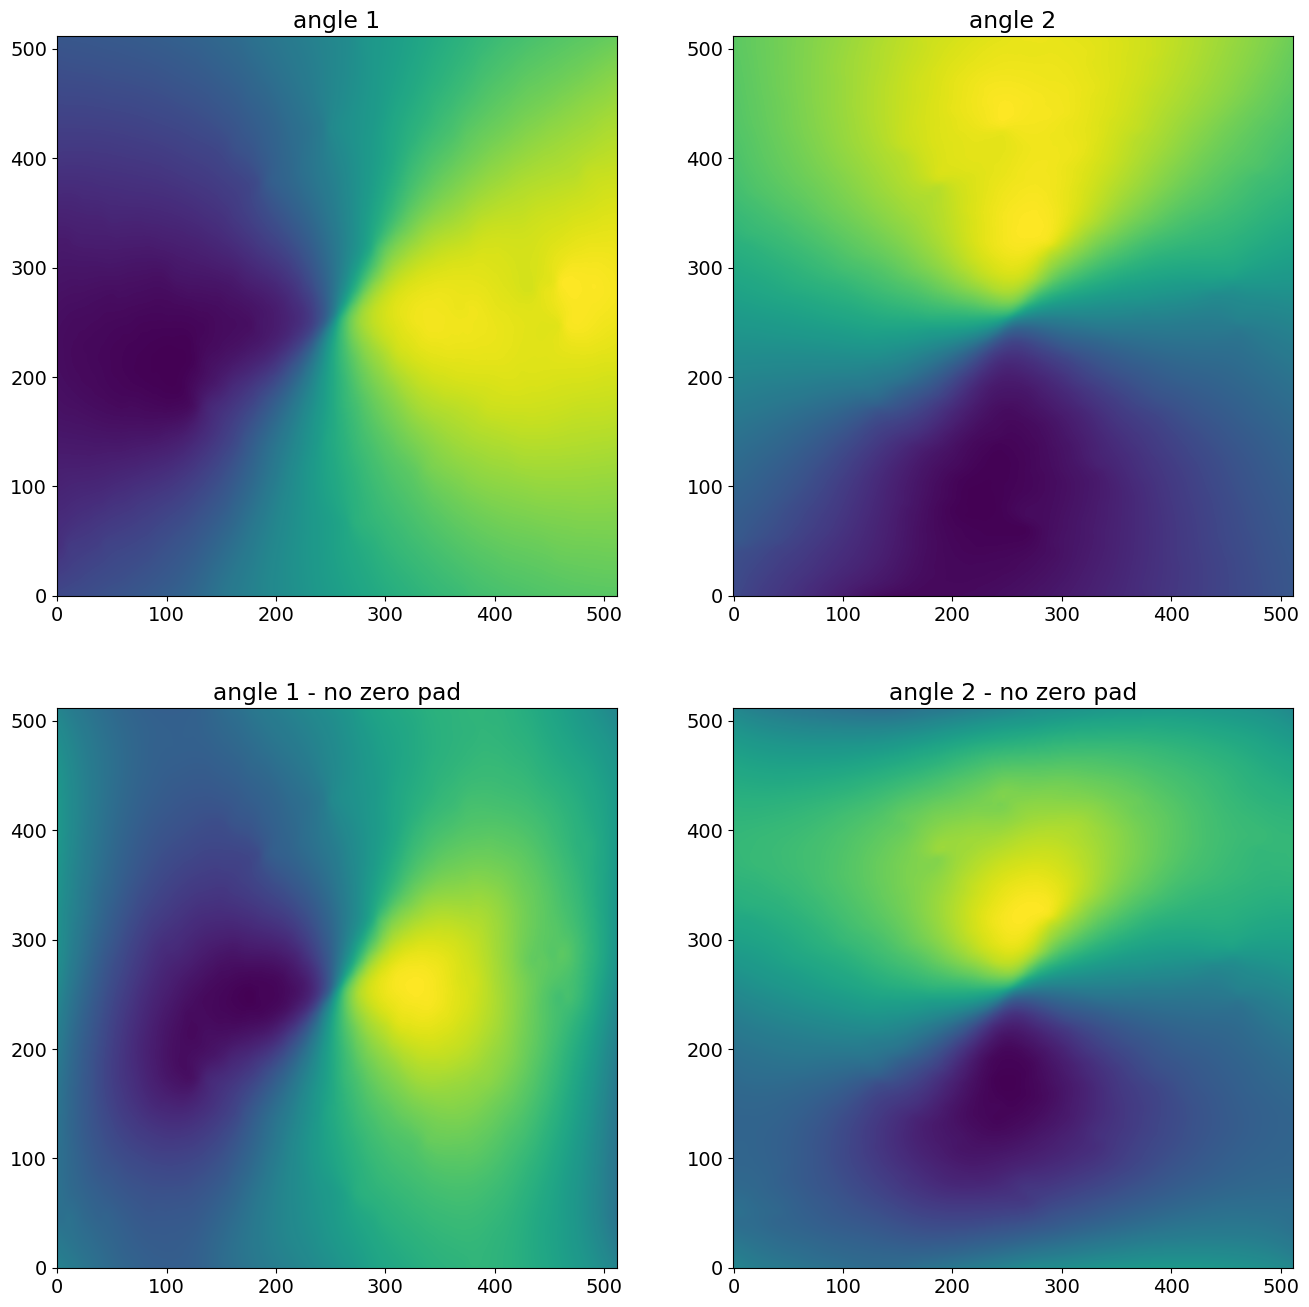

In [11]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(angx,origin="lower")
ax[0,0].set_title('angle 1')
ax[0,1].imshow(angy,origin="lower")
ax[0,1].set_title('angle 2')
ax[1,0].imshow(angx_nopad,origin="lower")
ax[1,0].set_title('angle 1 - no zero pad')
ax[1,1].imshow(angy_nopad,origin="lower")
ax[1,1].set_title('angle 2 - no zero pad')
fig.savefig('padding_cropped.png')